In [2]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.applications.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
    ShapDisplay2
)

import time
import numpy as np


In [3]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)

In [4]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    # CategoricalVariable([
    #     "type_A", "type_B", "type_C", "type_D", 
    #     "type_E", "type_F", "type_G", "type_H", 
    #     "type_I", "type_J", "type_K", "type_L",
    # ]),
    CategoricalVariable([
        "A", "B", "C", "D", 
        "E", "F", "G", "H", 
        "I", "J", "K", "L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 250
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

x_ref, _ = ds.sample_valid_x(1000)
y_ref = [f_obj(x_ref[i]) for i in range(len(x_ref))]
X_ref = np.array(x_ref)
y_ref = np.array(y_ref)

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

"""Modelling"""
print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

Ground truth model
RMSE: 0.0000
rRMSE: 0.0000
CPU times: user 5.55 s, sys: 127 ms, total: 5.67 s
Wall time: 5.7 s


In [5]:
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )


start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

run time (s): 21.19526481628418
Surrogate model
RMSE: 0.0001
rRMSE: 0.0468


In [7]:
# %%time
# model = gtm
# X = x_ref
# features = [i for i in range(X_tr.shape[1])]

# pdd = PartialDependenceDisplay.from_surrogate_model(
#     model, 
#     X, 
#     features, 
#     categorical_features=categorical_feature_idx, 
#     feature_names=feature_names,
#     grid_resolution=20,
#     kind='both',
#     centered=True,
#     # figsize=[30, 7],
#     inverse_categories_map=inverse_categories_map,
#     legend_locations=["lower left", "upper left", "lower left"],
#     figsize=[21, 5]
#     )

In [8]:
# model = gtm

# explainer_train_true = ShapDisplay.from_surrogate_model(
#     X_tr, 
#     model, 
#     X_tr, 
#     feature_names=feature_names,
#     categorical_features=categorical_feature_idx,
#     categories_map=categories_map,
# )

In [9]:
# %%time
# features = [i for i in range(X_tr.shape[1])]

# explainer_train_true.dependence_plot(features, sort_based_on_importance=False, figsize=[21, 5])

In [10]:
# %%time
# model = gtm
# X = X_tr

# feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
#     model, 
#     X, 
#     categorical_features=categorical_feature_idx,
#     feature_names=feature_names,
# )

In [11]:
# %%time
# model = gtm
# X = X_tr

# feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
#     model, 
#     X, 
#     feature_names=feature_names,
#     categorical_features=categorical_feature_idx,
# )

CPU times: user 191 ms, sys: 26.8 ms, total: 218 ms
Wall time: 229 ms


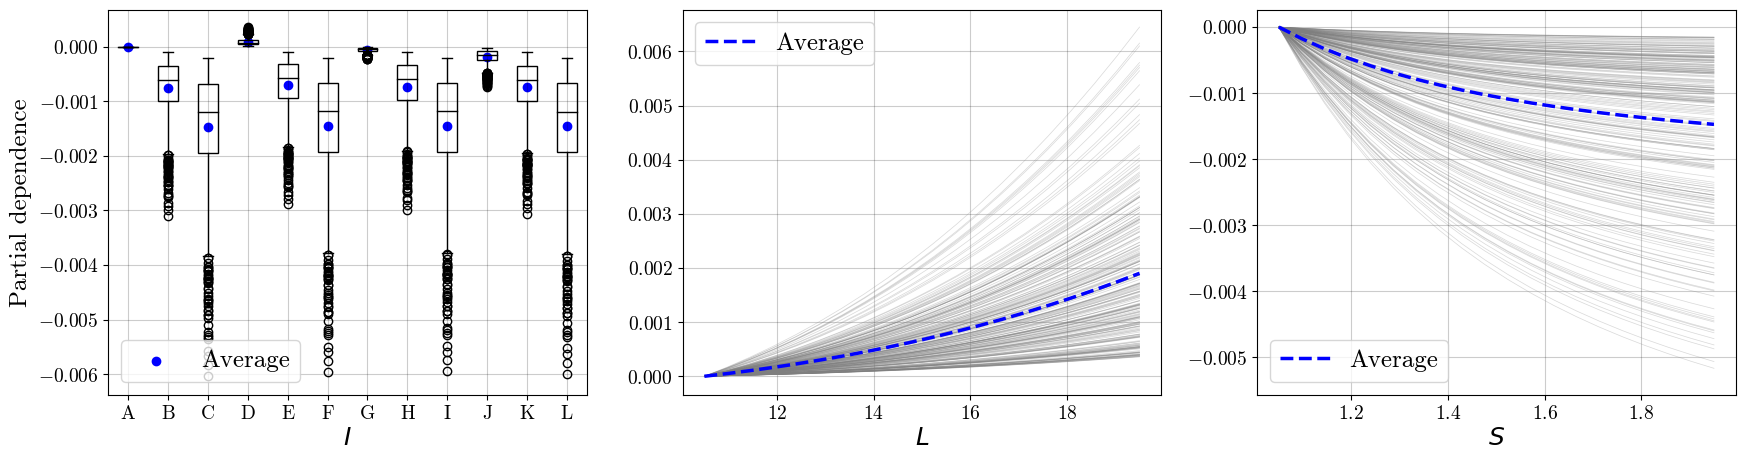

In [15]:
%%time
model = gtm
X = x_ref
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    # figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    legend_locations=["lower left", "upper left", "lower left"],
    figsize=[21, 5]
    )

In [19]:
model = sm

explainer_train = ShapDisplay2.from_surrogate_model(
    X_tr, 
    model, 
    X_tr, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
    categories_map=categories_map,
)

CPU times: user 44.5 ms, sys: 6.69 ms, total: 51.2 ms
Wall time: 48.6 ms


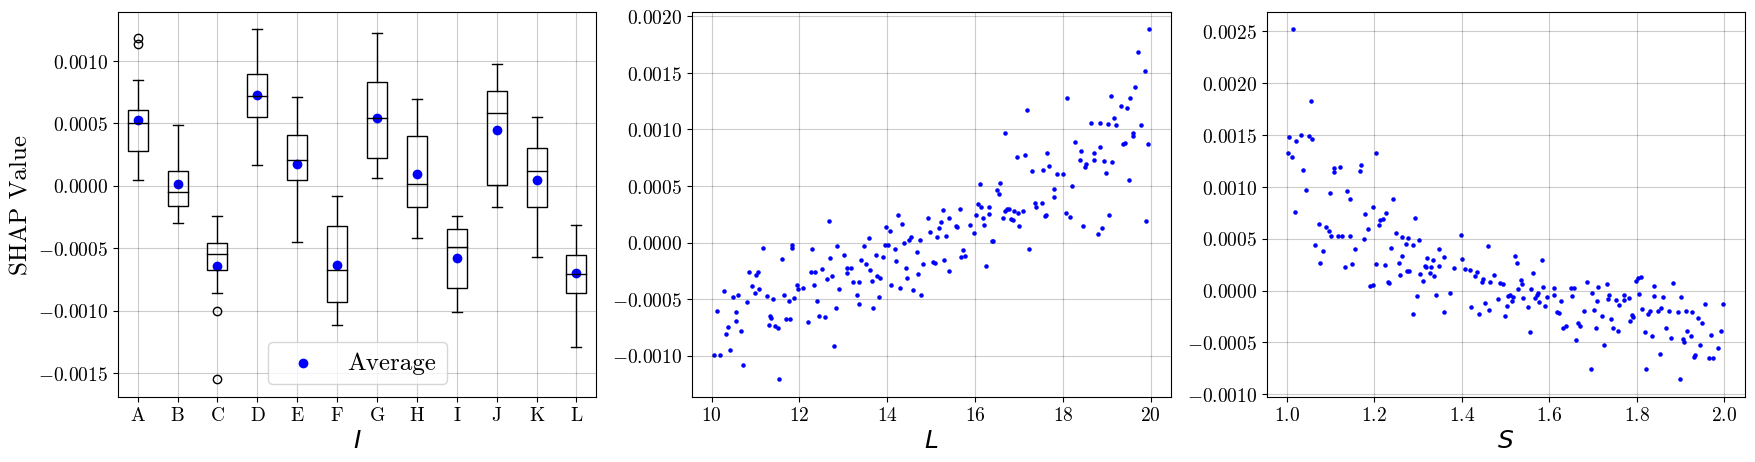

In [20]:
%%time
features = [i for i in range(X_tr.shape[1])]

shap_dependence = explainer_train.dependence_plot(features, sort_based_on_importance=False, figsize=[21, 5])

CPU times: user 5min 58s, sys: 4min 30s, total: 10min 28s
Wall time: 1min 32s


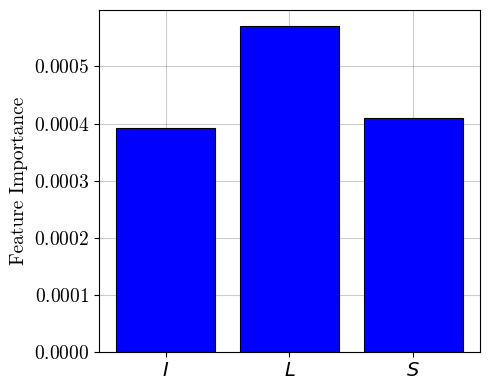

In [13]:
%%time
model = sm
X = X_tr

pd_feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

CPU times: user 29.9 s, sys: 18.1 s, total: 47.9 s
Wall time: 6.61 s


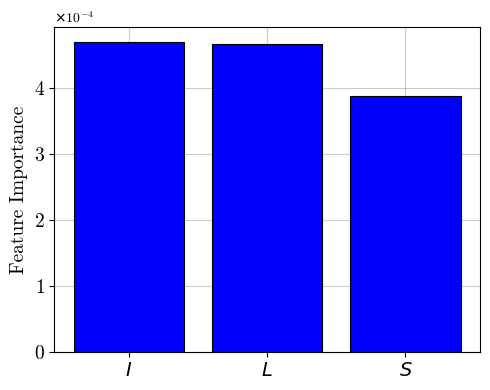

In [14]:
%%time
model = sm
X = X_tr

shap_feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
)

In [21]:
pdd.figure_.savefig("aiaa_abstract/cantilever/pdp_dependence_cantilever.pdf", format="pdf", bbox_inches="tight", dpi=750)
shap_dependence.savefig("aiaa_abstract/cantilever/shap_dependence_cantilever.pdf", format="pdf", bbox_inches="tight", dpi=750)
pd_feature_importance.fig.savefig("aiaa_abstract/cantilever/pdp_feature_importance.pdf", format="pdf", bbox_inches="tight", dpi=750)
shap_feature_importance.fig.savefig("aiaa_abstract/cantilever/shap_feature_importance.pdf", format="pdf", bbox_inches="tight", dpi=750)

